# Base de données d'un service de VTC

## Etude d'une campagne promotionnelle

Un code promotionnel a été envoyé aux utilisateurs d'un service de VTC. Pendant 5 jours, leurs courses effectuées leur rapportaient 5 fois plus de point de fidélité qu'à l'accoutumée. 

- Analyse du nombre d'utilisateurs ayant enregistré le code sur leur app.
- Analyse du taux de conversion : nombre d'utilisateurs ayant effectivement bénéficié du code promotionnel. 
- Analyse du coût / bénéfice moyen du code promo par utilisateur

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

###1ère vue d'ensemble des 2 sets de données

le dataset rides contient les courses effectuées ou demandées mais non finalisées pour un service de VTC sur environ 3 mois.

In [0]:
rides = pd.read_csv('rides.csv')
rides.head()

,ride_id,user_id,loyalty.status,booking_id,isGuest,loyalty_points_earned,price.loyalty.points_spent,price_nominal,price_after_discount,state,quote_date
0,357a545ef665da69dd86ac33ae817f3a,c6f3a631ae33a84c343dd9c553889337,1,1ea36f95a86a5a876456ce66587f4882,False,0,NaN,5.48,5.80,not_completed,2017-03-01 11:07:49
1,5714536c4b4b1b10c4cd8ac907537044,0bad5fc7936b072d8de8749b9dd608c6,1,NaN,False,0,NaN,4.72,4.72,not_completed,2017-03-02 22:45:02
2,5c8f5dec570b6597090f8b30ea33b0af,0bad5fc7936b072d8de8749b9dd608c6,1,NaN,False,5,NaN,4.72,4.72,completed,2017-03-02 22:45:22
3,0f37be24f23a15746eb8774e7a1bd934,37169a3d6636e14afabb1dbe01f5c83e,0,NaN,False,8,NaN,7.68,7.68,completed,2017-03-03 00:22:45
4,67f054abb8b60132dd7c19cb30e74e10,b89d8219faa82966c7b33ee69b484ad2,3,NaN,False,7,NaN,4.00,4.00,completed,2017-03-04 03:32:15


le dataset event se concentre sur le code promotionnel. Il repertorie les enregistrements du code dans l'application ( "coupon_created" ) ou les courses réalisées en bénéficiant du code ( "other_coupon_action" ).

In [0]:
events1 = pd.read_csv('events.csv')
events1.head()
#je l'appelle events1 pour y revenir ensuite 

,event_id,ride_id,type,user_id,promocode_name
0,457113065c424d25eff17823ad888162,NaN,other_coupon_action,c045abae8a3110ea6cec54b2f49f9f2d,89f13478125cee693ce7f76fedf01808
1,06e5ceb932743b583dc4349f617d1fde,NaN,coupon_created,c33cc932b7a4feb6f51d7ed1077faa05,8041613eff4408b9268b66430cf5d9a1
2,f08b5f110a9e2e9c3eac3f03e8ad801b,NaN,coupon_created,da03b00f7dd32fa31b800ecb762ef1df,308dd493382b32ebf486da92fdeaf38d
3,4265bc09df57f4fb6991f832b24e643c,NaN,coupon_created,0928a1d559774b05be5e6926920d2873,c4afe8e1914a1f612ca82d59ec72c771
4,4a5d1f58698acb12ca4da6b24535693d,NaN,coupon_created,960025162805d2c5942334c5ed200528,308dd493382b32ebf486da92fdeaf38d


In [0]:
totalriders=f"il y a {rides.user_id.nunique()} utilisateurs uniques enregistrés dans le set \'rides\'"
totalriders

"il y a 180692 utilisateurs uniques enregistrés dans le set 'rides'"

###Filtrage 

Le set 'rides' est beaucoup trop volumineux par rapport aux informations qui m'intéressent. 

Dans un 1er temps, je mets en forme de la colonne quote_date pour ne sélectionner que les 5 jours qui m'intéressent.
Par exemple, '2017-03-01 11:07:49' devient '2017-03-01'.


Ensuite, je ne veux garder que :

- les courses terminées ('completed')
- ayant eu lieu du 17 au 21 mai inclus (jours pendant lesquels le code promo était opérationnel)

Aussi, je supprime les colonnes booking_id (infos inutiles dans ce cas), isGuest (colonne corrélée à la colonne loyalty_points_earned), et price.loyalty.points_spent (si une course a été payée avec des points, elle n'a pas pu en rapporter à l'utilisateur, et j'ai déjà prévu de vérifier cela plus bas).


In [0]:
rides.rename(columns={'loyalty_points_earned':'lp_earned','price_after_discount':'ad_price',
                      'loyalty.status':'loyalty_level','quote_date':'date' },inplace=True)
rides.date = rides.date.apply(lambda x : x[:10]) 
rides.date = pd.to_datetime(rides.date)
rides2 = rides[(rides.date > '2017-05-16') & (rides.date < '2017-05-22')]
rides2 = rides2[(rides.state =='completed') ]
rides2.drop(['booking_id','isGuest','price.loyalty.points_spent'],axis=1,inplace=True)
rides2.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,ride_id,user_id,loyalty_level,lp_earned,price_nominal,ad_price,state,date
237,bb85aff73ae15b27632c520ecf9bd58c,78e328025997c14eceb2bd3a13b23795,1,10,6.43,6.72,completed,2017-05-17
238,4afe23695ba43d436b115c294c2f64d2,8b0b91ae335b298a960d2052ed970d87,2,6,4.00,4.00,completed,2017-05-18
239,c48a1f5cb7bf71b5278cbb2967399dd5,4d8ae342aa247a23494460a02211ba51,3,8,4.56,4.56,completed,2017-05-18
250,623c2c44ec7709c3c791fa5728448d01,d9f9d0b7c75bdf88d8ac3b2e3c5ced79,3,9,5.48,5.48,completed,2017-05-19
252,4151effb5a7998e13a60a4710c238d80,73dd38be4f6a294a9caad81643a405b2,3,9,4.95,4.95,completed,2017-05-19
255,5b36fd8175ac9d0331f6abee692ea9a5,db5ac86cc05e59a3289625918646feee,3,7,4.00,4.00,completed,2017-05-20
462,f93104b264fb4f2f361e09e7386161f8,b7e736916b5b00398bd91d7be32f8793,3,8,4.81,4.81,completed,2017-05-19
463,29750b7039b98185926d4579c3e5e7ec,bec6de2792168e524aac80fd6060ee9e,0,1,4.43,0.00,completed,2017-05-19
464,9e6d7f7a4cf4dc412c4c412fe0d8d80f,52a5237b32e89b2a1e65b2ae9c22b8df,2,9,6.68,6.68,completed,2017-05-20
472,818180fd56f18df75b7f92716cd4c4f8,5aa18c133c7cacc6b7649e67f20f41e7,0,0,6.53,6.53,completed,2017-05-18


In [0]:
print(rides2.shape[0])
print(rides2.user_id.nunique())
# nombre de rangs du fichier VS nombre d'utilisateurs uniques repertoriés dans le ficher rides
rides2.to_csv('rides2.csv',index=False)

81825
40850


In [0]:
rides2 = pd.read_csv('rides2.csv')
rides2.isnull().sum()
# vérification de l'absence de données manquantes

ride_id          0
user_id          0
loyalty_level    0
lp_earned        0
price_nominal    0
ad_price         0
state            0
date             0
dtype: int64

In [0]:
rides2.shape

(81825, 8)

In [0]:
toutes_courses_confondues = rides[(rides.date > '2017-05-16')&(rides.date < '2017-05-22') ]
courses_avant = rides[(rides.date < '2017-05-17')]
courses_après = rides[(rides.date > '2017-05-21')]
print (toutes_courses_confondues.shape[0],courses_avant.shape[0],courses_après.shape[0])

110737 1318269 16658


Rides2 contient donc 81 825 rangs, correspondant à 81 825 courses complétées entre les 17 et 21 mai.

En comptant les courses non complétées dans le même crénau de jours, on montait à 110 737 courses.

Il y avait 1 318 269 courses complétées ou non repertoriées avant ces dates, et 16 658 courses repertoriées après.

### Nombre d'enregistrements du code promotionnel

In [0]:
events = events1[(events1.promocode_name=='promocode')] #selection de la campagne à analyser
# le nombre d'utilisateurs uniques ayant au moins enregistré le code promo 
claimers = f"il y a eu {events.user_id.nunique()} utilisateurs uniques ayant au moins enregistré le code dans leur application."
claimers

'il y a eu 9805 utilisateurs uniques ayant au moins enregistré le code dans leur application.'

In [0]:
verif = events[events.type=='coupon_created']
verif.user_id.nunique()

9805

le nombre d'utilisateurs uniques correspond bien. J'ai choisi de seulement filtrer par 'promocode' dans l'étape précédente pour garder les ride_id repertoriées avec les 'other_coupon_action'.

In [0]:
#filtrage d'une colonne superflue
events.drop('event_id',axis=1,inplace=True)

In [0]:
events.shape

(41988, 4)

In [0]:
print(events.user_id.nunique())
print(rides2.user_id.nunique())

9805
40850


9 805 utilisateurs ont enregistré le code dans leur app sur les 40 805 ayant complété des courses dans le créneau de dates étudiées.

In [0]:
convertis = pd.merge(events,rides2, on='user_id',how='inner')
convertis[convertis.duplicated(['user_id','ride_id_y'])]
convertis.user_id.nunique()

7004

### Taux de conversion

In [0]:
convertisbis = convertis.groupby('user_id').agg(sum)
convertis_reels = convertisbis[convertisbis.lp_earned>0].reset_index()
activated = f"{convertis_reels.shape[0]} utilisateurs ont utilisé le code promotionnel au cours des dates imparties, soit un taux de conversion de {round(convertis_reels.shape[0]*100/events.user_id.nunique(),0)}%."
activated

'6877 utilisateurs ont utilisé le code promotionnel au cours des dates imparties, soit un taux de conversion de 70.0%.'

127 utilisateurs n'ont pas gagné de points de fidélité, malgré des courses complétées pour certains, d'où la différence entre le 7004 utilisateurs.

### Vérification avec l'un des 127 utilisateurs :

In [0]:
faux_convertis = convertisbis[convertisbis.lp_earned==0]
print(faux_convertis.shape)
faux_convertis.head(1)

(127, 4)


,loyalty_level,lp_earned,price_nominal,ad_price
user_id,,,,
0298574839ee4cede781ab8bfff2e4bc,0,0,8.6,0.0


In [0]:
rides[rides.user_id=='0298574839ee4cede781ab8bfff2e4bc']

,ride_id,user_id,loyalty_level,booking_id,isGuest,lp_earned,price.loyalty.points_spent,price_nominal,ad_price,state,date
1406581,9201d0a0bbe36a37fdd343382819a3e6,0298574839ee4cede781ab8bfff2e4bc,0,NaN,False,0,NaN,4.29,0.0,not_completed,2017-05-21
1414564,450d9af26d4636365acde2fe5510c0bb,0298574839ee4cede781ab8bfff2e4bc,0,NaN,False,0,NaN,4.34,0.0,not_completed,2017-05-21
1415359,ae6cab70ea0f50a4ae904f878c5ae1d0,0298574839ee4cede781ab8bfff2e4bc,0,NaN,False,0,NaN,4.30,0.0,completed,2017-05-21


Hypothèse : ces 127 personnes n'étaient pas toutes des clients d'affaires(isGuest = 1, un utilisateur affilié à une entreprise ne gagne pas de points pour lui-même), mais certains ont pu vouloir essayer de cumuler 2 promotions disctinces. Dans le cas au-dessus, le prix final était de 0€, ce qui explique l'absence de points attribués.

**Mise en graphique de la répartition des 6877 utilisateurs ayant profité de la promotion :**

In [0]:
#ditribution des convertis
convert_distrib = convertis_reels.merge(convertis, how = 'inner', on = ['user_id'])
cd = convert_distrib.groupby('user_id').agg('mean').reset_index()
cd.head()

,user_id,loyalty_level_x,lp_earned_x,price_nominal_x,ad_price_x,loyalty_level_y,lp_earned_y,price_nominal_y,ad_price_y
0,000e99b20d433fd8e5661c72bd8b6d20,108.0,396.0,238.05,238.05,3.0,11.000000,6.612500,6.612500
1,0018e1fbfa6dccb58da89ace3f4465a6,0.0,10.0,9.84,9.84,0.0,5.000000,4.920000,4.920000
2,001940ba5831818d888f8b1a0030a25c,99.0,308.0,201.74,182.16,3.0,9.333333,6.113333,5.520000
3,002083606dbb4e3a2d527443888f8184,432.0,1552.0,1004.64,986.08,3.0,10.777778,6.976667,6.847778
4,002ebebbcc5dbcdc464d162281219e3a,4.0,20.0,12.20,11.46,2.0,10.000000,6.100000,5.730000


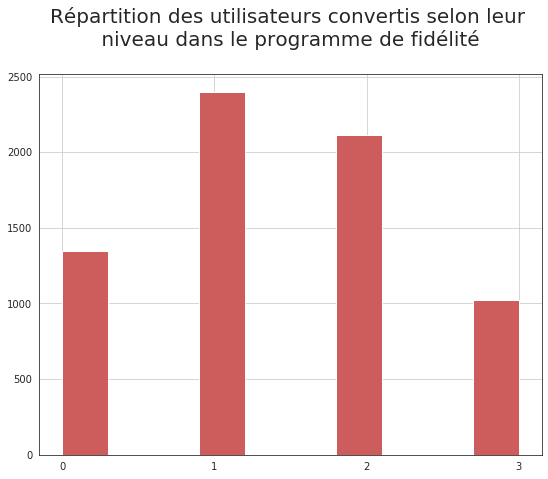

In [0]:
sns.set_style("white")
fig, ax = plt.subplots()
cd.loyalty_level_y.hist(ax=ax, figsize=(9,7),color=['indianred'])
from pylab import MaxNLocator
xa = ax.get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
plt.title('Répartition des utilisateurs convertis selon leur \n niveau dans le programme de fidélité \n',fontsize= 20)
plt.savefig('repartition_convertis.png', bbox_inches='tight')
plt.show()

In [0]:
nonbenef = pd.merge(cd,events, how = 'outer', on = 'user_id',indicator=True)

Nonbenef est un set des ID de tous les utilisateurs n'ayant pas profité du code promotionnel alors qu'ils l'avaient enregistré.

In [0]:
nonbenef =set(events.user_id.tolist())-set(convertis_reels.user_id.tolist())
len(nonbenef)

2928

In [0]:
cd.user_id.nunique() + len(nonbenef)
# les chiffres sont cohérents avec les résultats précédents.

9805

In [0]:
non_convertis = events[events.user_id.isin(nonbenef)==True]
# extractions du dataset 'Events' des ID des utilisateurs non convertis
non_convertis_bis = pd.merge(non_convertis,rides,on='user_id',how='inner')
# croisement des ID réupérés avec ceux du dataset originel 'rides'
print(non_convertis_bis.user_id.nunique())

#explication dessous
len(set(events.user_id.unique())-set(rides.user_id.unique()))

2473


455

Dans ma liste de non-convertis, je m'attendais à retrouver les 2 928 utilisateurs de mon set Nonbenef, mais en créant ensuite le dataset Non_convertis, je n'arrivais qu'à 2 473 utilisateurs.

Il y a 455 utilisateurs non convertis enregistrés dans le dataset Events mais pas dans le dataset de base Rides.

Ils ont ouvert leur application pour enregistrer le code promotionnel, mais n'ont ensuite même plus fait la moindre simulation de course, probablement par manque de besoin du service ou préférence pour la concurrence. Ils n'ont même pas de courses répertoriées comme non complétées.

### Distribution des 2473 utilisateurs non convertis

Sans surprise, ce sont des gens globalement beaucoup moins usagers du service. La moitié d'entre eux sont au niveau 0. En comparaison, environ 45% des utilisateurs convertis étaient des utilisateurs au niveau 2 ou 3.

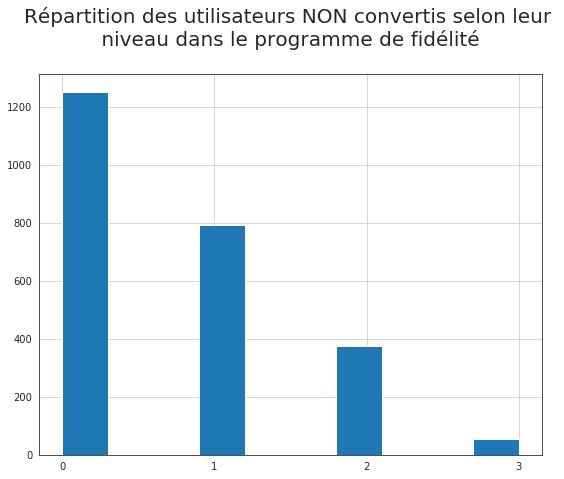

In [0]:
fig, ax = plt.subplots()
non_convertis_bis[['loyalty_level','user_id']].groupby('user_id')['loyalty_level'].agg('unique').apply(lambda x: x[0]).hist(ax=ax, figsize=(9,7))
xa = ax.get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
plt.title('Répartition des utilisateurs NON convertis selon leur \n niveau dans le programme de fidélité \n',fontsize= 20)
plt.savefig('repartition_NONconvertis.png', bbox_inches='tight')
plt.show()

### Nombre de courses effectuées avec le code promotionnel :

In [0]:
completed_rides = events[events.type == 'other_coupon_action'].dropna()
print(completed_rides.shape[0],',', completed_rides.ride_id.nunique())

32178 , 32178


Les courses dans Events sans ride_id correspondent aux enregistrements du code promo par les utilisateurs. 

A partir de là, je suppose qu'il y a donc eu 32 178 courses effectuées avec ce code promo.

In [0]:
# courses_promo pour courses complétées avec le code promo activé
courses_promo = pd.merge(completed_rides,rides2, on='ride_id',how='inner')
courses_promo=courses_promo[courses_promo.promocode_name=='promocode']
courses_promo.to_csv('course_promo.csv',index=False)
courses_promo.shape

(14218, 11)

Cependant, il n'y a que 14 218 courses répertoriées après la fusions de toutes les courses complétées d'Events et celles de Rides2, le dataset qui regroupe l'ensemble des courses complétées dans les dates limites.

In [0]:
missing_id =set(events1.ride_id.tolist())-set(rides.ride_id.tolist())
len(missing_id)

62148

Dans les ride_id du dataset original Events, il y en a 62 148 qui ne sont pas présents dans le fichier originel Rides. Cela affecte la fusion que j'opère entre mes datasets Completed_Rides et Rides2. 

Mon dataset Courses_promo qui regroupe l'ensemble des courses effectuées avec le code promo ne contient que 14 218 références. 

### Proportion des courses effectuées avec le code promo selon le niveau atteint au programme Fidélité par l'utilisateur

Je poursuis l'analyse des 14 218 courses répertoriées :

In [0]:
completed_rides_id = (completed_rides.ride_id.tolist())
rides2['code_oui'] = np.where(rides2['ride_id'].isin(completed_rides_id)==True, 1, 0)
rides2['code_non'] = np.where(rides2['ride_id'].isin(completed_rides_id)==False, 1, 0)
rides2.drop_duplicates(inplace=True)
rides2.to_csv('rides2.csv',index=False)

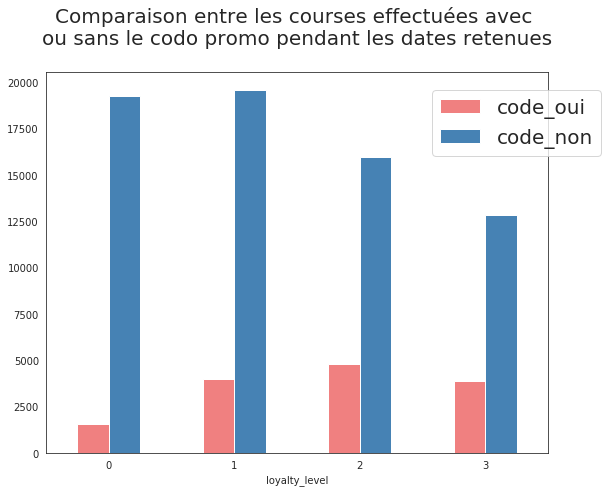

In [0]:
fig, ax = plt.subplots()
rides2[['code_oui','code_non','loyalty_level']].groupby(['loyalty_level']).agg('sum').plot.bar(ax=ax, figsize=(9,7),color=['lightcoral', 'steelblue'])
plt.legend(bbox_to_anchor=(.75, .98), loc=2,prop={'size': 20})
plt.title('Comparaison entre les courses effectuées avec \nou sans le codo promo pendant les dates retenues\n',fontsize= 20)
plt.savefig('repartition_courses.png', bbox_inches='tight')
plt.xticks(rotation = 0)
plt.show()

In [0]:
a=rides2[(rides2.code_oui==1)]
a.shape[0]

#nombre de courses effectuées avec le code promo par des utilisateurs de niveau 2 ou 3 au programme fidélité

14218

Sur 81 825 courses complétées, effectuées, et répertoriées entre les 17 et 21 mai inclus, 67 607 ont été effectués sans le code promo.


In [0]:
rides2.code_non.value_counts()

1    67607
0    14218
Name: code_non, dtype: int64

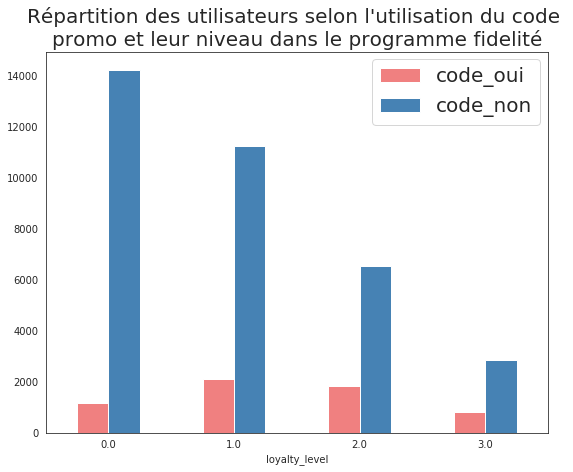

In [0]:
#nouveau dataset concentré sur les utilisateurs
riders_comparison = rides2.groupby('user_id').agg('mean').reset_index()

fig, ax = plt.subplots()
riders_comparison[['loyalty_level','code_oui','code_non']].groupby(['loyalty_level']).agg('sum').plot.bar(ax=ax, figsize=(9,7),color=['lightcoral', 'steelblue'])
plt.title('Répartition des utilisateurs selon l\'utilisation du code \npromo et leur niveau dans le programme fidelité',fontsize=20)
plt.legend(bbox_to_anchor=(.63, 1.01), loc=2,prop={'size': 20})
plt.savefig('repartition_riders.png', bbox_inches='tight')
plt.xticks(rotation = 0)
plt.show()

## Analyse du coût de la campagne promotionnelle par rapport à son bénéfice immédiat

In [0]:
price = rides2.groupby('code_oui').agg('mean')
price['taux_reduc'] = round(100-(price.ad_price*100/price.price_nominal),1)
price

,loyalty_level,lp_earned,price_nominal,ad_price,code_non,taux_reduc
code_oui,,,,,,
0,1.331667,7.613516,6.105540,5.858004,1.0,4.1
1,1.772261,8.765157,6.150967,6.012955,0.0,2.2


Les utilisateurs ayant profité du code promo ont complété des courses avec un taux de réduction moyen (2.2%) sur le prix final inférieur à celui des utilisateurs ayant utiliser le service normalement (4.1%). 

On peut déduire que la perspective de 5 fois plus de points supplémentaires attribués par courses a motivé les utilisateurs convertis à payer des prix plus élevés qu'habituellement.

In [0]:
a=price.lp_earned[price.code_non==0][1]
#moyenne des points récoltés par les NON utilisateurs du code promo
b = price.lp_earned[price.code_non==0][1]*5 
# 5 fois plus de points attribués sur la moyenne des points récoltés par les convertis au code
c=round((b-a)*0.1,2)
# c est le coût de 10 centimes par point bonus attribué aux convertis au code promo
d=round(price.ad_price[price.code_non==0][1] - price.ad_price[price.code_non!=0][0],2)
sommaire = f"le coût moyen de la campagne par utilisateur est de {c} €, tandis que le gain de revenu moyen par rapport aux utilisateurs qui n'ont pas consommé le code promo est de {d} €."
print(sommaire)

le coût moyen de la campagne par utilisateur est de 3.51 €, tandis que le gain de revenu moyen par rapport aux utilisateurs qui n'ont pas consommé le code promo est de 0.15 €.


In [0]:
price

,loyalty_level,lp_earned,price_nominal,ad_price,code_non,taux_reduc
code_oui,,,,,,
0,1.331667,7.613516,6.105540,5.858004,1.0,4.1
1,1.772261,8.765157,6.150967,6.012955,0.0,2.2


In [0]:
price2 = rides2.groupby(['loyalty_level','code_oui'],as_index=True).agg('mean').reset_index()
price2.to_csv('price2.csv')

Maintenant, je veux calculer le coût et le bénéfice de la campagne par statut dans le programme de fidélité :

(une course effectuée avec le code promo rapporte 5 fois plus de points fidélité qu'à l'accoutumée)

In [0]:
price2['promo_cost']=  np.where(price2.code_non==0,round(((price2.lp_earned*5)-price2.lp_earned)*0.1,2) ,0)
# colonne affichant le coût moyen de la promo par converti selon son niveau dans le programme fidélité
a = list(price2.ad_price[price2.code_oui==0]) #prix final moyen payé par les utilisateurs normaux
b = list(price2.ad_price[price2.code_oui==1]) #prix final moyen payé par les convertis au code promo
from operator import sub
c= list( map(sub, b, a) ) #différence (le gain) moyenne de revenu entre les convertis et les autres
price2['extra_revenue']=0
price2.loc[price2.code_oui==1, 'extra_revenue'] = [round(element,2) for element in c]
price2.set_index(['loyalty_level','code_oui'],inplace=True)
price2['difference'] = price2.extra_revenue - price2.promo_cost
price2

lp_earned  price_nominal  ...  extra_revenue  difference
loyalty_level code_oui                            ...                           
0             0          5.621849       6.536318  ...           0.00        0.00
              1          6.516825       6.770102  ...           0.46       -2.15
1             0          7.518958       6.107276  ...           0.00        0.00
              1          8.110187       6.331301  ...           0.26       -2.98
2             0          9.030785       5.889887  ...           0.00        0.00
              1          9.585955       6.060567  ...           0.21       -3.62
3             0          8.977805       5.725822  ...           0.00        0.00
              1          9.332388       5.826957  ...           0.17       -3.56

[8 rows x 7 columns]

Les convertis au code ont payé très légèrement plus cher en moyenne que les autres après réduction appliquée.

Le plus gros gain de revenu moyen par utilisateur converti est celui au niveau 0, est monte à 46 centimes par course. Cependant, le coût moyen de l'opération pour cet untilisateur converti type est de 2.61€ (correspondant aux point fidélité bonus attribués et valant chacun 10 centimes).

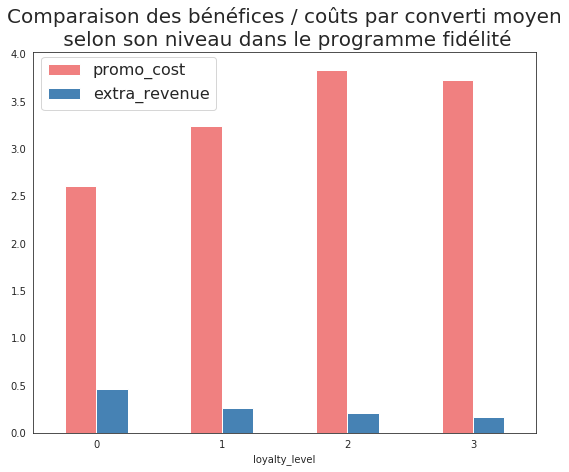

In [0]:
# cb pour signifier cost / benefit
cb = price2.iloc[1::2, :].reset_index()
fig, ax = plt.subplots()
cb.plot(x='loyalty_level',y=[ 'promo_cost','extra_revenue' ],kind = 'bar',ax=ax, figsize=(9,7),color=['lightcoral', 'steelblue'])
plt.title('Comparaison des bénéfices / coûts par converti moyen\n selon son niveau dans le programme fidélité',fontsize=20)
plt.legend(bbox_to_anchor=(.0, 1.01), loc=2,prop={'size': 16})
plt.savefig('Comparaison_benef_coût.png', bbox_inches='tight')
plt.xticks(rotation = 0)
plt.show()

In [0]:
cb_bis = cb.drop(['code_oui','code_non','price_nominal','lp_earned'],axis=1)
cb_bis.rename({'loyalty_level':'statut','ad_price':'prix final','promo_cost':'coût du code','extra_revenue':'gain moyen'},axis=1,inplace=True)
cb_bis

,statut,prix final,coût du code,gain moyen,difference
0,0,6.551346,2.61,0.46,-2.15
1,1,6.249811,3.24,0.26,-2.98
2,2,5.939471,3.83,0.21,-3.62
3,3,5.642999,3.73,0.17,-3.56


D'un point de vue financier, ça n'a pas été une campagne efficace. Le coût moyen de la campagne est démesuré face au gain de revenu effectif, presque résiduel.

La campagne a surtout profité à des utilisateurs déjà bien fidélisés par le service VTC. 

Près de la moitié d'entre eux étaient déjà au niveau 2 ou 3 au moment de la campagne et ont donc vu l'offre promotionnelle comme une aubaine pour gagner des avantages supplémentaires à peu de frais. Les utilisateurs à ces niveaus là du programme Fidélité sont les plus coûteux dans le cadre de cette campagne. 

A l'inverse, les utilisateurs au niveau 0 ont largement snobé la campagne. Les a-t-elle seulement atteint ? Ils sont seulement 1153 à avoir profité de l'offre sur les plus de 15 400 utilisateurs de niveau Rouge ayant complété au cours des dates indiquées.